Github: https://github.com/CamWood7/DLGAN

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, InputLayer

# Description of Problem

Generative Adversarial Networks consist of two neural networks, a generator and a discriminator, that work against each other in a competitive manner. The generator creates new data that resemble real data, in this case the monet's, while the discriminator attempts to distinguish between real and generated data. The goal of the generator is to produce data that can fool the discriminator, while the discriminator aims to become better at identifying fake data.

In this Monet Style Transfer Competition, participants are tasked with building a GAN to generate at least 7,000 images in the style of Monet. The generator network will learn to mimic Monet's style by producing images with similar color choices and brush strokes. The input to the generator network will be real portraits of nature. 

# EDA

We'll start by loading in both the Monet image set and the Nature data set. There are 300 Monet's and 7038 nature images, so there is a large imbalance. These images are 256x256 in size, with 3 color channels.

In [2]:
monetPath = glob('../input/gan-getting-started/monet_jpg/*.jpg')
normalPath = glob('../input/gan-getting-started/photo_jpg/*.jpg')

print(f'Total number of Monet images: {len(monetPath)}')
print(f'Total number of Regular images: {len(normalPath)}')

Total number of Monet images: 300
Total number of Regular images: 7038


We can first take a look at a handful of Monet's.

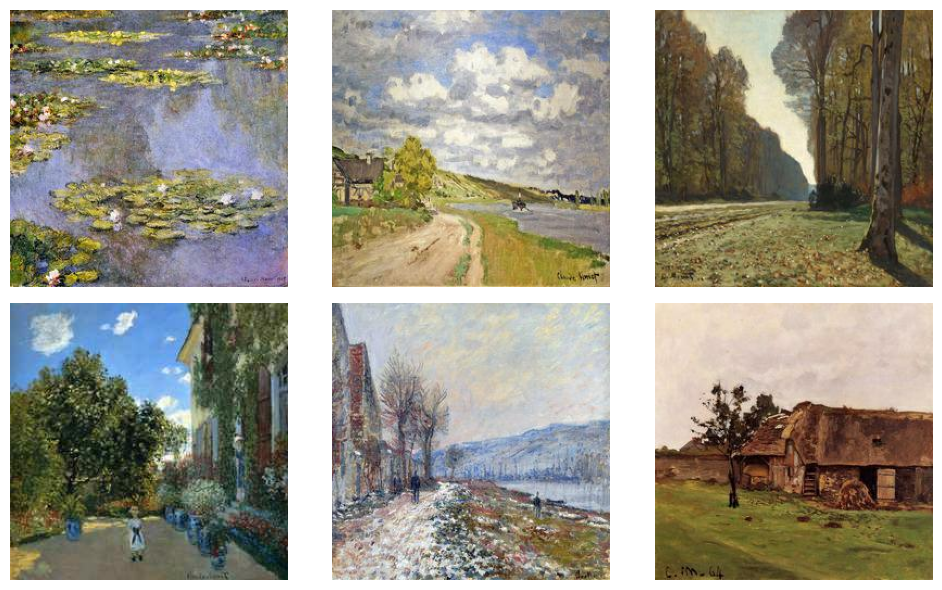

In [3]:
plt.figure(figsize=(10,6))
for i, path in enumerate(monetPath[:6]):
    img = load_img(path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

And now at some nature portraits. Very pretty.

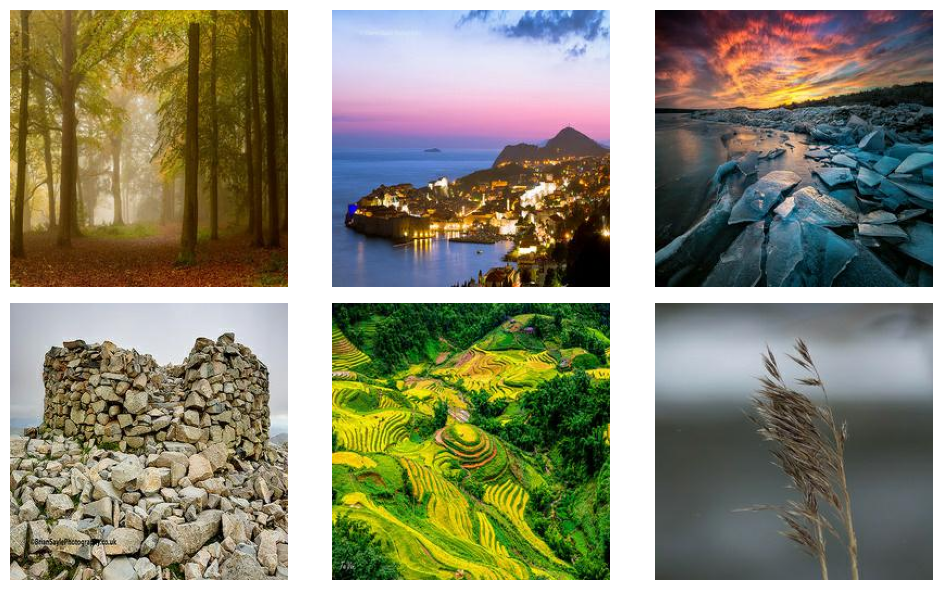

In [4]:
plt.figure(figsize=(10,6))
for i, path in enumerate(normalPath[:6]):
    img = load_img(path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Next we define the function we'll use to load the images into an array, and limit the nature images to 300 to keep training time low. We also normalize the images to be between [-1,1], which will become more relevant later when constructing the models.

In [5]:
def loadImgs(path):
    images = []
    count = 1
    for filename in os.listdir(path):
        img = load_img(os.path.join(path, filename))
        img = img_to_array(img)
        images.append(img)
        count += 1
        if count == 301:
            break
    images = np.array(images)
    images = (images / 127.5) - 1
    return images

In [6]:
realImgs = loadImgs('../input/gan-getting-started/monet_jpg/')
print(realImgs.shape)
fakeImgs = loadImgs('../input/gan-getting-started/photo_jpg/')
print(fakeImgs.shape)

(300, 256, 256, 3)
(300, 256, 256, 3)


# Model Building and Training

First we'll start off with our Generator. The input layer takes in the 256x256 images, and is followed by multiple convolutional layers. The filters start at 64 and increase to 128 and 256, capturing increasingly complex features. The kernl size is 5x5 and striedes of 2x2 to downsample the imput. LeakyReLU allows for better gradient flow since it allows negative values. We then have multiple transposed convolutional layers to unsample the images, scaling back from 256 all the way down to 3 for the RGB channels. The final layer produces the output image with 3 channels, and using the tanh function giving pixel values between -1 and 1.

In [7]:
def generatorSetUp():
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 256, 3)))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh'))
    return model

Now we'll set up the Discriminator. Similarly, it takes in a 256x256x3 image, and then then moves into the convolutional layers that increase the number of filters from 64 to 512 to extract hierarchical features from the input. We downsample at each step, and include dropout layers of 30% to prevent overfitting. We finally flatten the layers into a 1D vector and pass this along to the final dense layer which uses a sigmoid function.

In [8]:
def discriminatorSetUp():
    model = Sequential()
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(256,256,3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

Here we define he GAN, which combines the two components.

In [9]:
def getTheGAN(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model

Now we'll initialize the two models, and optimizes the discriminator using Adam and focuses on the accuracy. We'll then do the same for the GAN itself. Binary Cross Entropy is ideal for binary classification problems (real vs. fake) and calculates how well the discriminator or GAN is performing at either generating images or discriminating them.

In [10]:
generator = generatorSetUp()
discriminator = discriminatorSetUp()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
gan = getTheGAN(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Here we specify that we want our batch size to be 32 images at a time and run for 50 epochs. After 50 epochs the notebook crashes in Kaggle.

In [11]:
batchSize = 32
epochs = 50

Now we can train the model. We'll loop through the number of epochs, and do the following:
1. Select a random batch of real and fake images
2. Generate some new fake images after passing the nature images.
3. Create labels and calculate the losses for each components of the GAN, and trin the discriminator.
4. Get the average and total GAN loss.
5. At the end of each epoch we'll output a generated image.

In [12]:
def trainThatGAN(generator, discriminator, gan, realImgs, epochs, batchSize):
    
    for epoch in range(epochs):

        print(epoch)
        real_images_batch = realImgs[np.random.randint(0, realImgs.shape[0], batchSize)]

        fake_images_batch = fakeImgs[np.random.randint(0, fakeImgs.shape[0], batchSize)]

        generated_images = generator.predict(fake_images_batch)

        real_labels = np.ones((batchSize, 1))*0.9
        fake_labels = np.ones((batchSize, 1))*0.1

        d_loss_real = discriminator.train_on_batch(real_images_batch, real_labels)

        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print(d_loss)

        g_loss = gan.train_on_batch(fake_images_batch, real_labels)
        print(g_loss)
        
        def genImage(generator, batch, n):
            genImages = generator.predict(batch)
            genImages = (genImages + 1)/2.0

            plt.figure(figsize=(4,4))
            for i in range(n):
                plt.subplot(4,4,i+1)
                plt.imshow(genImages[i])
                plt.axis('off')

            plt.show()
        
        genImage(generator, fake_images_batch, 1)

In [13]:
def genImage(generator, batch, n):
    genImages = generator.predict(batch)
    genImages = (genImages + 1)/2.0

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(genImages[i])
        plt.axis('off')

    plt.show()

# Results

Below we'll see the generated images progressively take shape of monet-like images, albeit very pixelated.

0


I0000 00:00:1728607426.861906      70 service.cc:145] XLA service 0x79ffb81078f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728607426.861969      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1728607429.456339      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[0.69663846 0.        ]
[array(0.6954601, dtype=float32), array(0.6954601, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


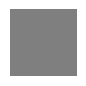

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.6948943 0.       ]
[array(0.6946958, dtype=float32), array(0.6946958, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


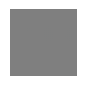

2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.69521713 0.        ]
[array(0.69510734, dtype=float32), array(0.69510734, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


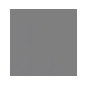

3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.69490373 0.        ]
[array(0.69488573, dtype=float32), array(0.69488573, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


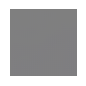

4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[0.69490886 0.        ]
[array(0.6949512, dtype=float32), array(0.6949512, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


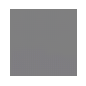

5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.69490755 0.        ]
[array(0.6950647, dtype=float32), array(0.6950647, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


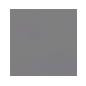

6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.6950507 0.       ]
[array(0.69537383, dtype=float32), array(0.69537383, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


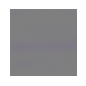

7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.6957893 0.       ]
[array(0.69620717, dtype=float32), array(0.69620717, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


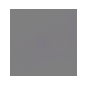

8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.69676846 0.        ]
[array(0.6974097, dtype=float32), array(0.6974097, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


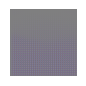

9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.6978558 0.       ]
[array(0.69873637, dtype=float32), array(0.69873637, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


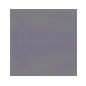

10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.6994581 0.       ]
[array(0.7006312, dtype=float32), array(0.7006312, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


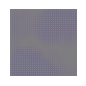

11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.7019416 0.       ]
[array(0.7035409, dtype=float32), array(0.7035409, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


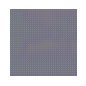

12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[0.70481455 0.        ]
[array(0.7063908, dtype=float32), array(0.7063908, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


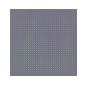

13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.70732903 0.        ]
[array(0.70870334, dtype=float32), array(0.70870334, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


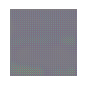

14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.71012855 0.        ]
[array(0.7119671, dtype=float32), array(0.7119671, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


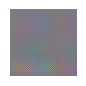

15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[0.71339256 0.        ]
[array(0.7153608, dtype=float32), array(0.7153608, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


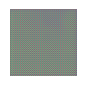

16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.71683824 0.        ]
[array(0.71903306, dtype=float32), array(0.71903306, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


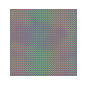

17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.7203108 0.       ]
[array(0.7222768, dtype=float32), array(0.7222768, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


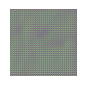

18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7235241 0.       ]
[array(0.7255155, dtype=float32), array(0.7255155, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


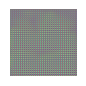

19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[0.72669554 0.        ]
[array(0.7286993, dtype=float32), array(0.7286993, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


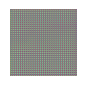

20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.7296939 0.       ]
[array(0.7314737, dtype=float32), array(0.7314737, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


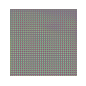

21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.73268056 0.        ]
[array(0.7345413, dtype=float32), array(0.7345413, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


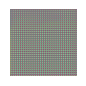

22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7354667 0.       ]
[array(0.7372532, dtype=float32), array(0.7372532, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


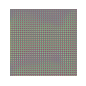

23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[0.7382316 0.       ]
[array(0.7400588, dtype=float32), array(0.7400588, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


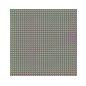

24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.7406095 0.       ]
[array(0.7421292, dtype=float32), array(0.7421292, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


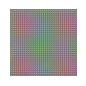

25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[0.7428051 0.       ]
[array(0.7443886, dtype=float32), array(0.7443886, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


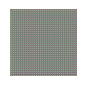

26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.744922 0.      ]
[array(0.74640244, dtype=float32), array(0.74640244, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


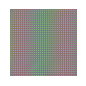

27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.74703383 0.        ]
[array(0.74851125, dtype=float32), array(0.74851125, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


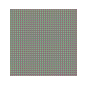

28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.74886227 0.        ]
[array(0.75015795, dtype=float32), array(0.75015795, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


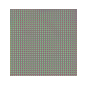

29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[0.7503363 0.       ]
[array(0.7514482, dtype=float32), array(0.7514482, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


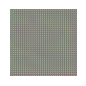

30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7517104 0.       ]
[array(0.7528828, dtype=float32), array(0.7528828, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


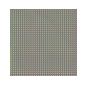

31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.75324434 0.        ]
[array(0.75445575, dtype=float32), array(0.75445575, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


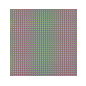

32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7546936 0.       ]
[array(0.7558176, dtype=float32), array(0.7558176, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


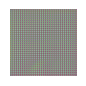

33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[0.7560811 0.       ]
[array(0.7572459, dtype=float32), array(0.7572459, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


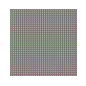

34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.75742257 0.        ]
[array(0.75842994, dtype=float32), array(0.75842994, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


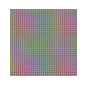

35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.75862384 0.        ]
[array(0.75960135, dtype=float32), array(0.75960135, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


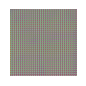

36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7597294 0.       ]
[array(0.76075596, dtype=float32), array(0.76075596, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


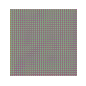

37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.76090026 0.        ]
[array(0.76188517, dtype=float32), array(0.76188517, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


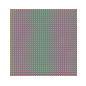

38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[0.7619549 0.       ]
[array(0.7628714, dtype=float32), array(0.7628714, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


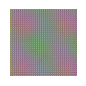

39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.76296544 0.        ]
[array(0.7639231, dtype=float32), array(0.7639231, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


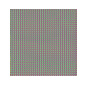

40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.76395404 0.        ]
[array(0.7648885, dtype=float32), array(0.7648885, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


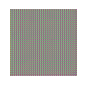

41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.7648586 0.       ]
[array(0.7656844, dtype=float32), array(0.7656844, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


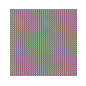

42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.7655791 0.       ]
[array(0.7662947, dtype=float32), array(0.7662947, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


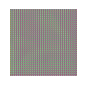

43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.76630557 0.        ]
[array(0.76713544, dtype=float32), array(0.76713544, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


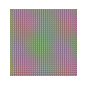

44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7671542 0.       ]
[array(0.76795775, dtype=float32), array(0.76795775, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


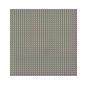

45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.76796913 0.        ]
[array(0.7687803, dtype=float32), array(0.7687803, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


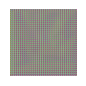

46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.76867557 0.        ]
[array(0.7693667, dtype=float32), array(0.7693667, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


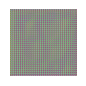

47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0.7693562 0.       ]
[array(0.7701041, dtype=float32), array(0.7701041, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


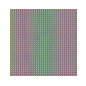

48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[0.77013046 0.        ]
[array(0.77090895, dtype=float32), array(0.77090895, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


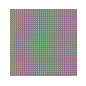

49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.7708961 0.       ]
[array(0.77164257, dtype=float32), array(0.77164257, dtype=float32), array(0., dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


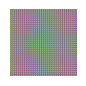

In [14]:
trainThatGAN(generator, discriminator, gan, realImgs, epochs, batchSize)

As we get closer to 50 epochs the images stay pixelated and don't really resemble anything. We can also see from the print statements that our loss starts very high at 70%, and stays fairly constant as time goes on, if not increasing early on. We'll discuss more in the next section.

# Conclusion and Discussion

As mentioned, our GAN model was not very successful in generating Monet look-alikes, and instead is pretty great at generating images of blobs and pixels. There could be a few reasons this is, one in particular catches my attention which is Mode Collapse. This happens when the generator only produces one type of output, resulting in the discriminator always getting the same type of fake input. To resolve this we could potentially send even smaller batches to the discriminator, or change the generator architecture.

A few other issues with the model could be:
1. Discriminator overfitting and thus isn't allowing our generator to improve because everything it outputs is marked as fake.
2. Our initial weights may be bad leading to bad model performance.
3. Maybe if the notebook didn't crash after 50 epochs it might get better, but that might be a stretch.

In the end, we still placed 80th, so not too shabby for just a blob of pixels!

In [15]:
outputDir = 'images'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
    
totalImg = 7000
batchSize = 50
imgsGen = 0

while imgsGen < totalImg:
    currentSize = min(batchSize, totalImg - imgsGen)
    fake_images_batch = fakeImgs[np.random.randint(0, fakeImgs.shape[0], batchSize)]
    generated_images = generator.predict(fake_images_batch)
    generated_images = (generated_images * 127.5 + 127.5)
    generated_images = generated_images.astype(np.uint8)
    for i in range(currentSize):
        img = Image.fromarray(generated_images[i])
        img.save(f"{outputDir}/image_{imgsGen+i+1}.png")
    
    imgsGen += currentSize
    print(f"Generated {imgsGen}/{totalImg}...")
    
with zipfile.ZipFile("images.zip", 'w', zipfile.ZIP_DEFLATED) as img_zip:
    for filename in os.listdir(outputDir):
        img_zip.write(os.path.join(outputDir, filename), arcname=filename)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Generated 50/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 100/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 150/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 200/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Generated 250/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 300/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Generated 350/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 400/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 450/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 500/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 550/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 600/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 650/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 700/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 750/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated 800/7000...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Gener